# ALD_U_N_2A

> Abstract: Access to level 2a product

In [1]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

viresclient: 0.7.2
pandas     : 1.2.4
xarray     : 0.17.0
matplotlib : 3.4.1



In [2]:
from viresclient import AeolusRequest
import datetime as dt
import matplotlib.pyplot as plt

request = AeolusRequest()

## Product information

Description of product.

Documentation:
- https://earth.esa.int/eogateway/catalog/aeolus-preliminary-hlos-horizontal-line-of-sight-wind-observations-for-rayleigh-and-mie-receivers


      Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.445MB)

      Downloading:  70%|██████▉   |  [ Elapsed: 00:00, Remaining: 00:00 ] (0.445MB)

      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.445MB)

DATA: <xarray.Dataset>
Dimensions:           (array_24: 24, array_25: 25, ica_dim: 344, observation: 444, sca_dim: 444)
Dimensions without coordinates: array_24, array_25, ica_dim, observation, sca_dim
Data variables:
    MCA_time_obs      (observation) float64 ...
    mie_altitude_obs  (observation, array_25) float64 ...
    MCA_extinction    (observation, array_24) float64 ...
    ICA_time_obs      (ica_dim) float64 ...
    ICA_extinction    (ica_dim, array_24) float64 ...
    SCA_time_obs      (sca_dim) float64 ...
    SCA_extinction    (sca_dim, array_24) float64 ...


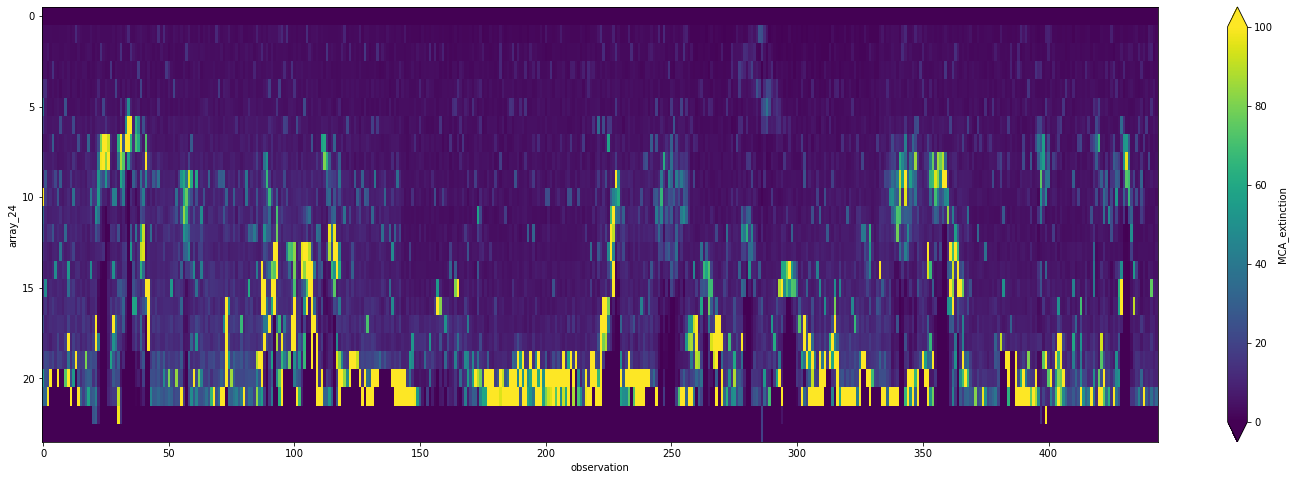

In [3]:

#import matplotlib
#from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
#import numpy as np
#from datetime import datetime

plt.rcParams["figure.figsize"] = (25,8)

request.set_collection('ALD_U_N_2A')


request.set_fields(
    observation_fields=[
        "MCA_time_obs",
        "mie_altitude_obs",
        "MCA_extinction",
    ],
    ica_fields=[
        "ICA_time_obs",
        "ICA_extinction",
    ],
    sca_fields=[
        "SCA_time_obs",
        "SCA_extinction",
    ],
)

data = request.get_between(
    start_time="2020-06-22T06:48:34Z",
    end_time="2020-06-22T08:16:58Z",
    filetype="nc",
    asynchronous=False
)

ds = data.as_xarray()

ds["MCA_extinction"].plot.pcolormesh(
    x="observation",
    yincrease=False,
    vmin=0,
    vmax=100
)

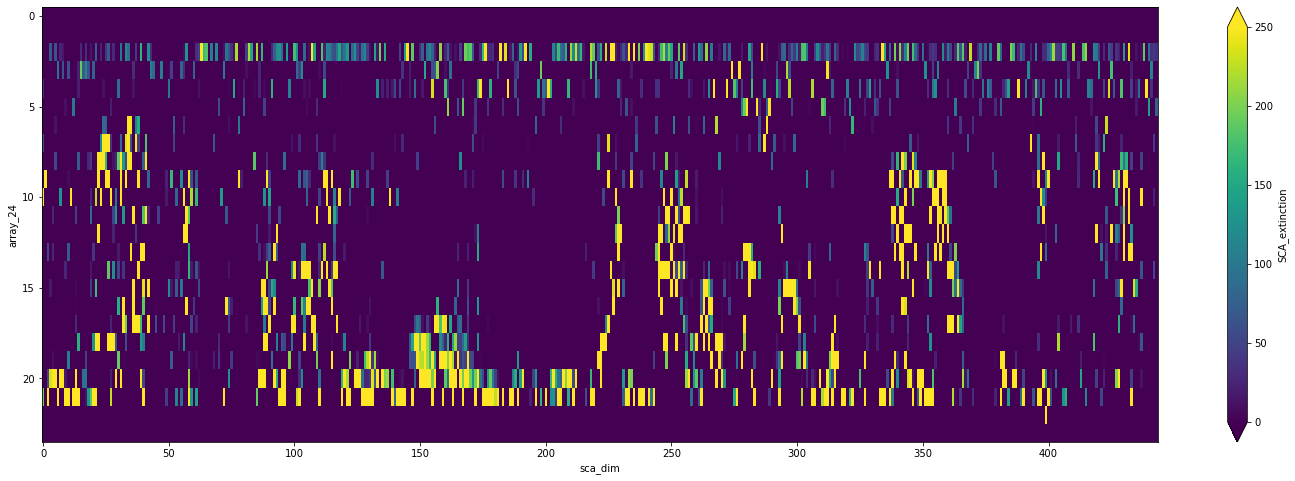

In [4]:

ds["SCA_extinction"].plot.pcolormesh(
    x="sca_dim",
    yincrease=False,
    vmin=0,
    vmax=250
)
